# Project Part 3

[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/brearenee/NLP-Project/blob/main/part3.ipynb)


**NLP Problem:** Predicting the speaker from Star Trek: The Next Generation script lines for 8 main characters.

In this third phase of my project, I'm developing a deep learning model for this NLP task.

As learned in Part 1 and Part 2, the initial dataset's structure is less than ideal. To start Part 3, we must once again parse and clean the raw JSON data and transform it into a structured DataFrame.

In [1]:
import pandas as pd
import json
import requests
url = 'https://raw.githubusercontent.com/brearenee/NLP-Project/main/dataset/StarTrekDialogue_v2.json'
response = requests.get(url)

##This CodeBlock is thanks to ChatGPT :-) 
if response.status_code == 200:
    json_data = json.loads(response.text)
    lines = []
    characters = []
    episodes = []
  
    # extract the information from the JSON file for the "TNG" series
    for series_name, series_data in json_data.items():
        if series_name == "TNG": 
            for episode_name, episode_data in series_data.items():
                for character_name, character_lines in episode_data.items():
                    for line_text in character_lines:
                        lines.append(line_text)
                        characters.append(character_name)
                        episodes.append(episode_name)
                     
    # Create a DataFrame from the extracted data
    df = pd.DataFrame({
        'Line': lines,
        'Character': characters,
    })

    # Remove duplicate lines, keeping the first occurrence (preserving the original order)
    df = df.drop_duplicates(subset='Line', keep='first')

    # Reset the index of the DataFrame
    df.reset_index(drop=True, inplace=True)

else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")
    
    
##Remove Outliers (Characters with less than 1200 lines)
character_counts = df['Character'].value_counts()
characters_to_remove = character_counts[character_counts < 1207].index
df = df[~df['Character'].isin(characters_to_remove)]


##Print Value Count. 
print(df['Character'].value_counts())


Character
PICARD     10798
RIKER       6454
DATA        5699
LAFORGE     4111
WORF        3185
CRUSHER     2944
TROI        2856
Name: count, dtype: int64


# BERT

I chose to use a Bidirectional Encoder Representations from Transformers model for my task.  BERT captures complex semantic relationships between words and entities in a sentence. This is beneficial for classification tasks involving natural language understanding.

I start with this pre-trained model and fine tune it to better fit my data. 

### Preprocessing


In [2]:
#Help with this notebook was taken from the following tutorial: 
#https://www.analyticsvidhya.com/blog/2021/12/multiclass-classification-using-transformers/

##Remove Riker because model is having a hard time. 
df= df[df['Character'] != 'RIKER']

#Split the data 
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=20)

#Converting our Character column into Categorical data
#encoded_dict = {'PICARD':0,'RIKER':1, 'DATA':2, 'LAFORGE':3, 
                #'WORF':4, 'CRUSHER':5, 'TROI':6 }
    

encoded_dict = {'PICARD':0,'DATA':1, 'LAFORGE':2, 
                'WORF':3, 'CRUSHER':4, 'TROI':5 }


train_df['Character'] = train_df.Character.map(encoded_dict)
val_df['Character'] = val_df.Character.map(encoded_dict)

from tensorflow.keras.utils import to_categorical

# Apply one-hot encoding to Categorical Data Labels
y_train = to_categorical(train_df.Character)
y_test = to_categorical(val_df.Character)

#We have successfully processed our Character column (target/y); 
#Now, it’s time to process our input text data using a tokenizer.



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Tokenizing


In [3]:
import transformers
from transformers import AutoTokenizer,TFBertModel

# bert-base-uncased is a smaller variants of the BERT model.
# Using Hugging Face Transformers library to load 
# pre-trained tokenizer associated with the bert-base-uncased model
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

# TFBertModel = pretrained BERT model for Tensor Flow
bert = TFBertModel.from_pretrained('bert-base-uncased')

#Input Data Modeling
#Tokenizing the input based on the previously loaded tokenizer. 
x_train = tokenizer(
    text=train_df.Line.tolist(),
    add_special_tokens=True,
    # max_length based on average line length from Part 1
    max_length=40,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)
x_test = tokenizer(
    text=val_df.Line.tolist(),
    add_special_tokens=True,
    max_length=40,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)


#The tokenized representation of the input text. 
input_ids = x_train['input_ids']

#Indicates which tokens in the input sequence should be attended to by the model and which ones should be ignored
attention_mask = x_train['attention_mask']


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# Model Building

In [4]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense

max_len = 40

# Input_ids and attention_mask are given as input layers. 
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")

# calling the bert model
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
# perform global max pooling on the input sequence
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)

# A dense layer with 128 units and ReLU activation is applied
# to the output of global max pooling.
out = Dense(128, activation='relu')(out)

# Dropout Layer
out = tf.keras.layers.Dropout(0.2)(out)

# More hidden layers
out = Dense(64,activation = 'relu')(out)
#out = Dense(32,activation = 'relu')(out)

# Final output layer
y = Dense(6,activation = 'softmax')(out)

# Establish the architecture of our neural network,
#connecting the input layers to the output layer.
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)

##  Allow updated weights for all layers after index 2
model.layers[1].trainable = True

# Model Compilation

Definte the hyerparameters and compile the model

In [5]:
# Adam optimizer, used for updating the weights during training
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=5e-05, # 5e-05 is the learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Categorical crossentropy loss function. 
# This is often used in multi-class classification problems where each sample can belong to only one class. 
loss =CategoricalCrossentropy(from_logits = False)

# metric used to evaluate the model's performance during training/validation. 
# 'balanced_accuracy' indicates that it considered class imbalance in it's accuracy.
metric = CategoricalAccuracy('balanced_accuracy'),

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

# Model Training

In [6]:
#Train the model! 
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
    
    
  epochs=4,
    batch_size=30
)


Epoch 1/4
790/790 [==============================] - 247s 284ms/step - loss: 1.2652 - balanced_accuracy: 0.5245 - val_loss: 1.1006 - val_balanced_accuracy: 0.5874
Epoch 2/4
790/790 [==============================] - 223s 282ms/step - loss: 1.0623 - balanced_accuracy: 0.6088 - val_loss: 1.0676 - val_balanced_accuracy: 0.6052
Epoch 3/4
790/790 [==============================] - 223s 282ms/step - loss: 0.9968 - balanced_accuracy: 0.6355 - val_loss: 1.0649 - val_balanced_accuracy: 0.6062
Epoch 4/4
790/790 [==============================] - 223s 282ms/step - loss: 0.9557 - balanced_accuracy: 0.6520 - val_loss: 1.0633 - val_balanced_accuracy: 0.6074


# Model Evaluation

In [7]:
# Run the predictions and see how we did. :-) 
import numpy as np
predicted_raw = model.predict({'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']})
predicted_raw[0]
y_predicted = np.argmax(predicted_raw, axis = 1)
y_true = val_df.Character

#Print results

from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import classification_report

print(classification_report(y_true, y_predicted))

predictions_val = model.predict({'input_ids': x_test['input_ids'], 'attention_mask': x_test['attention_mask']})
y_pred_val = predictions_val.argmax(axis=1)

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(y_true, y_predicted)
print(f'Balanced Accuracy: {balanced_acc:.4f}')

185/185 [==============================] - 19s 87ms/step
              precision    recall  f1-score   support

           0       0.63      0.78      0.70      2146
           1       0.63      0.67      0.65      1182
           2       0.67      0.58      0.62       803
           3       0.49      0.45      0.47       634
           4       0.63      0.32      0.42       579
           5       0.42      0.32      0.37       575

    accuracy                           0.61      5919
   macro avg       0.58      0.52      0.54      5919
weighted avg       0.60      0.61      0.60      5919

  1/185 [..............................] - ETA: 17s

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

185/185 [==============================] - 16s 88ms/step
Balanced Accuracy: 0.5204


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

Accuracy: 0.6074
Confusion Matrix:
[[1683  161   74   86   39  103]
 [ 178  795   26  152   12   19]
 [ 191   68  463   25   24   32]
 [ 138  164   23  286    7   16]
 [ 204   33   61   16  183   82]
 [ 259   39   41   24   27  185]]


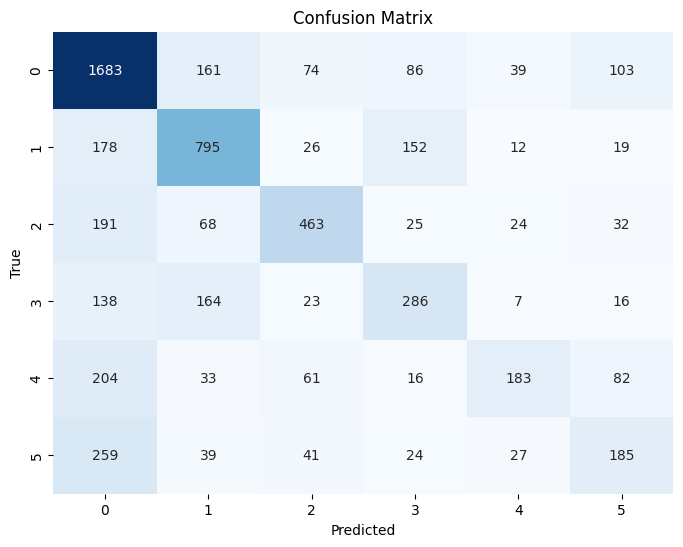

In [8]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


# Calculate accuracy
accuracy = accuracy_score(y_true, y_predicted)
print(f'Accuracy: {accuracy:.4f}')

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_predicted)
print('Confusion Matrix:')
print(conf_matrix)

# Display confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

I spent a lot of time adjusting hyper parameters (epoch, batch size, max_length for tokens, learning rate, hidden layers) to try and increase my accuracy, but I kept overfitting. Unfortunately it doesn't want to budge past 60%.  

I knew this task was going to be difficult when I started it.  My dataset is small and it's based on a TV script that relies on accents to distinguish characters and accents dont fully exist in text data. I love The Next Generation, but I wouldn't be able to tell the difference by looking at the script either.  I bet this 60% accuracy is significantly better than I could do.  
